Task 3 : Model Explainability 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib  # For loading your saved model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Fraud Detection Week 5and6\Fraud-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enable inline plotting and init js

In [16]:
import shap
import matplotlib.pyplot as plt
%matplotlib inline 
 # Critical for Jupyter
shap.initjs()  # Enables JS for force plots
plt.rcParams['figure.figsize'] = (10, 6)  # Bigger plots

Load data and best model

In [2]:

data = pd.read_csv('../data/processed/processed_fraud_data.csv')  
# Separate features (X) and target (y)
X = data.drop('class', axis=1)  # 'class' is the fraud label
y = data['class']

# Split into train/test (same as in modeling.ipynb to match)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

load the best model

In [6]:
# Load the saved XGBoost model
model = joblib.load('../models/best_model.pkl')  # Adjust if your file name differs
y_pred = model.predict(X_test)  # For finding examples
print(X_test.shape, y_test.shape)

(30223, 15) (30223,)


Extract and Visualize Built-in feature importance baseline

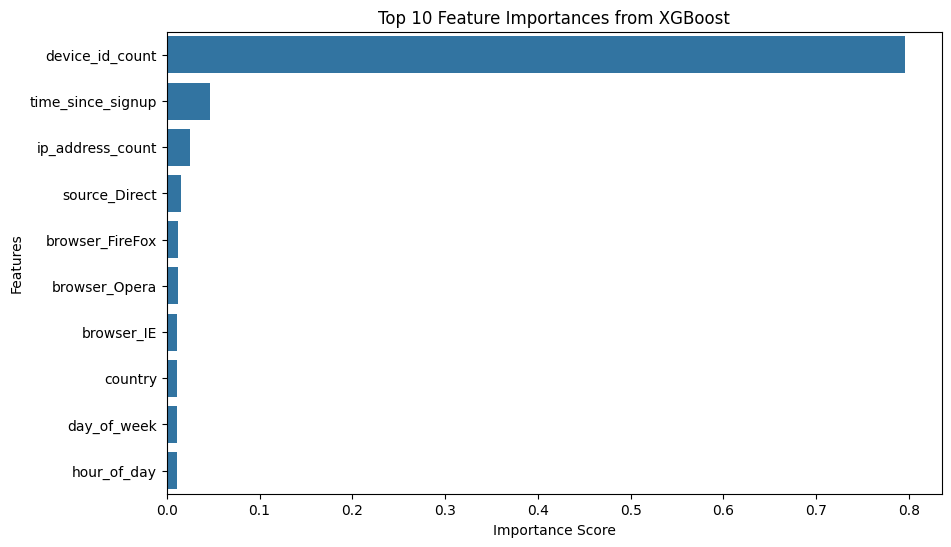

In [7]:
# Get feature importances from XGBoost
importances = model.feature_importances_
feature_names = X.columns  # Your feature list, e.g., 'purchase_value', 'time_since_signup', etc.

# Create a DataFrame for sorting
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Top 10 Feature Importances from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

The bar plot shows the top features contributing to the model's decisions, based on gain (how much each split improves predictions). For example, if 'time_since_signup' ranks high, short times between signup and purchase might signal fraud."

Perform SHAP Analysis

In [8]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set (this might take a minute on large data)
shap_values = explainer.shap_values(X_test)

Generate Summary Plot(global view)

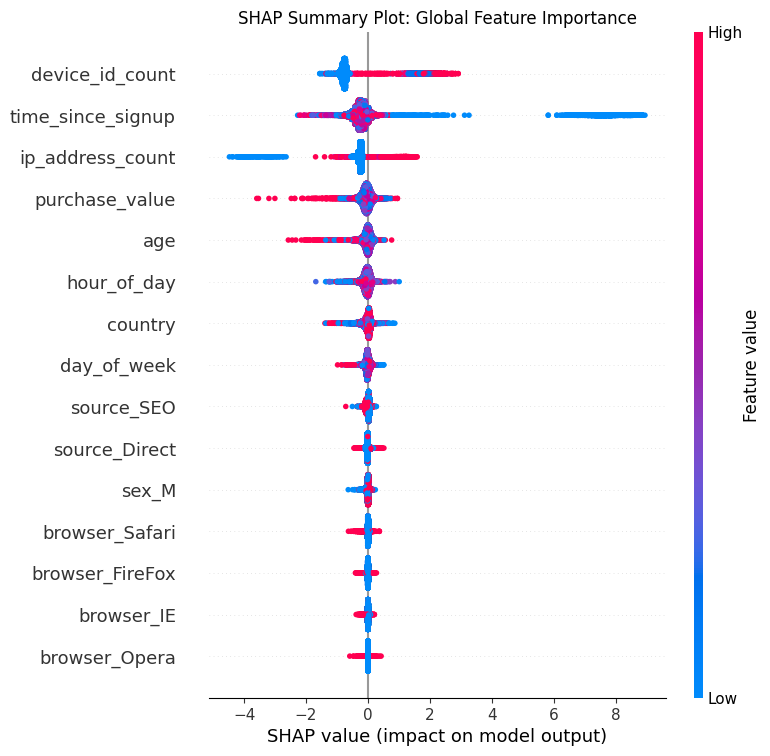

In [19]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: Global Feature Importance')
plt.show()

Find examples for force plots (local view)

In [11]:
# Confusion matrix to verify
cm = confusion_matrix(y_test, y_pred)
print(cm)  # Helps see TP/FP/FN counts

# Find indices
tp_idx = np.where((y_test == 1) & (y_pred == 1))[0][0]  # First TP
fp_idx = np.where((y_test == 0) & (y_pred == 1))[0][0]  # First FP
fn_idx = np.where((y_test == 1) & (y_pred == 0))[0][0]  # First FN

[[25858  1535]
 [  901  1929]]


Generate Force Plots

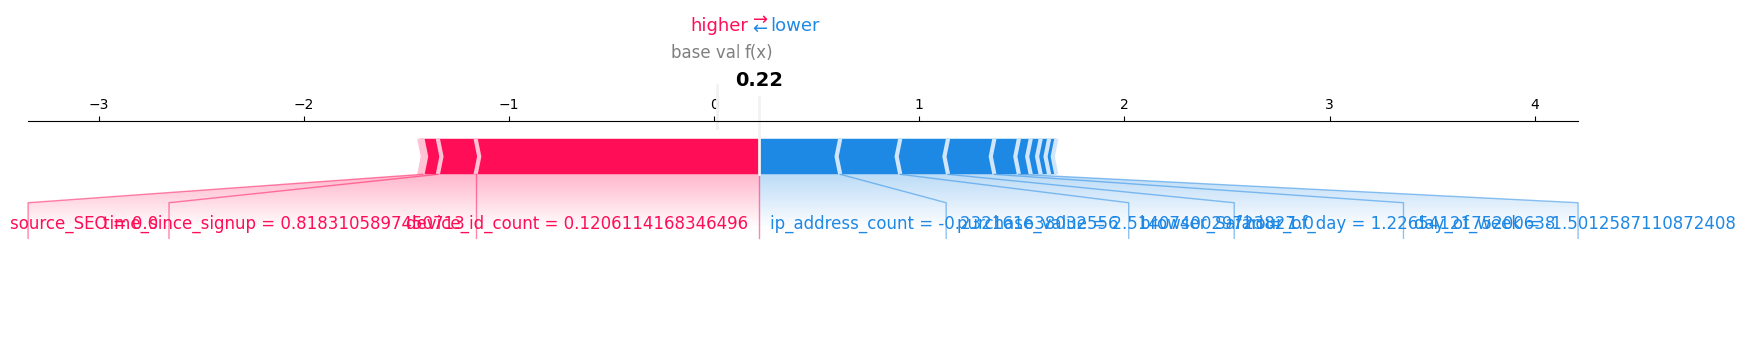

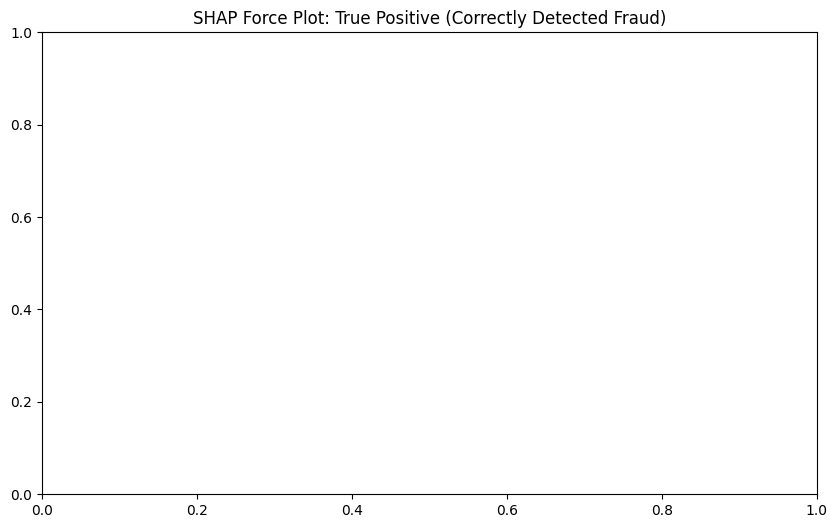

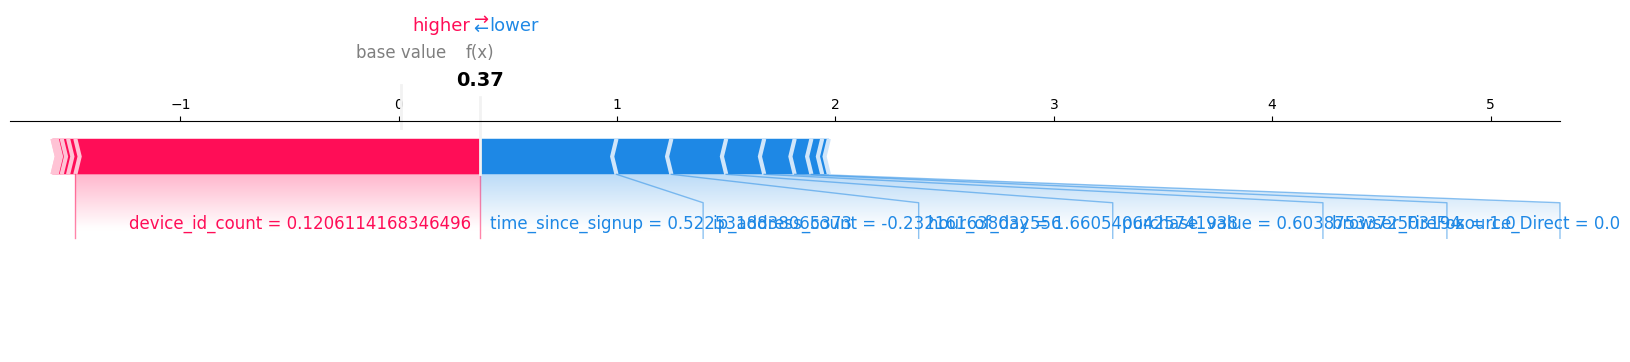

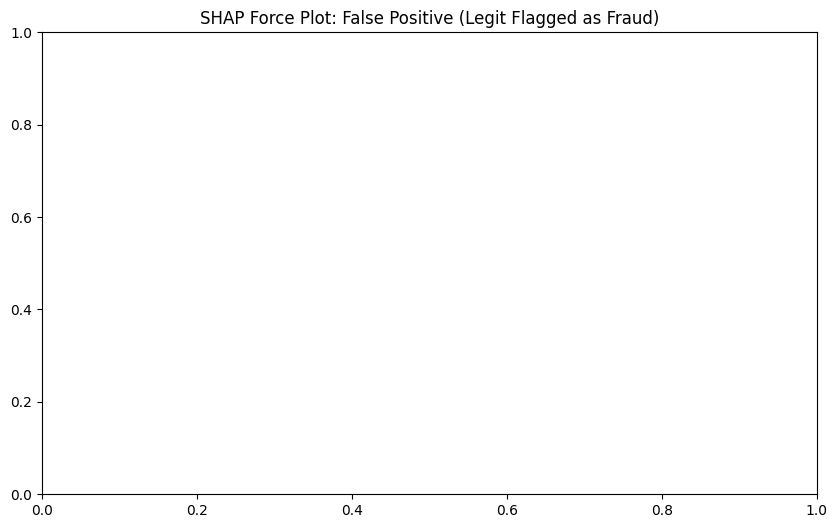

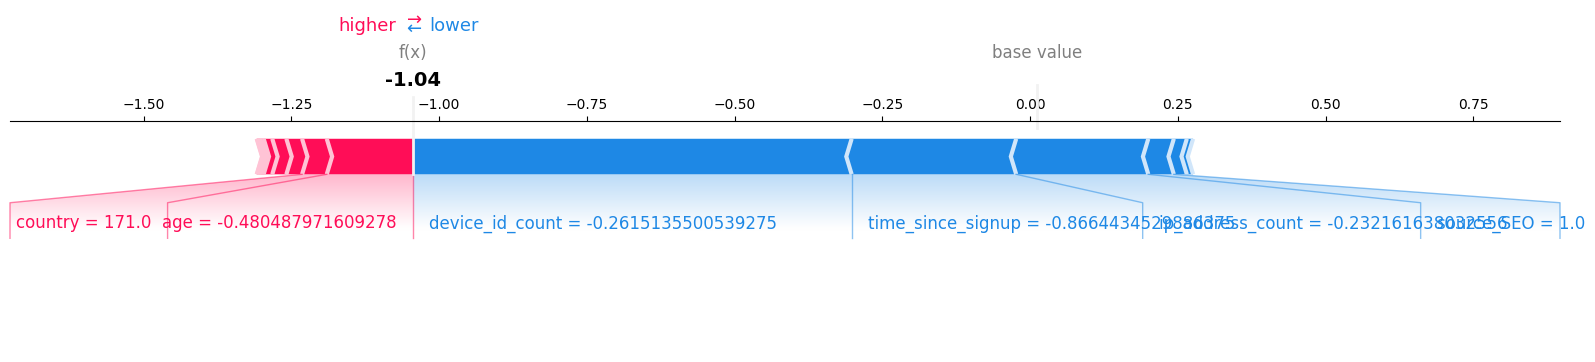

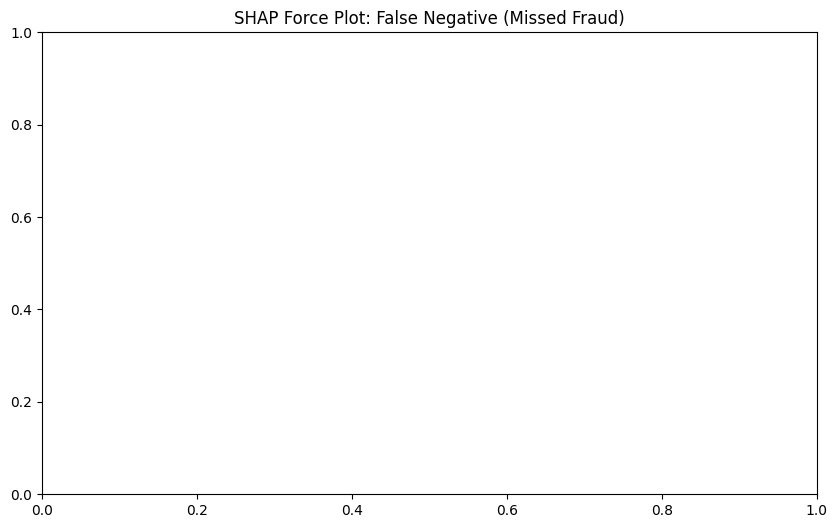

In [21]:
# Your indices (keep your code to find tp_idx, fp_idx, fn_idx on the sample if used)
# If you used full X_test for shap_values, use original indices

# True Positive
shap.plots.force(explainer.expected_value, shap_values[tp_idx], X_test.iloc[tp_idx], matplotlib=True, show=True)
plt.title('SHAP Force Plot: True Positive (Correctly Detected Fraud)')
plt.show()

# False Positive
shap.plots.force(explainer.expected_value, shap_values[fp_idx], X_test.iloc[fp_idx], matplotlib=True, show=True)
plt.title('SHAP Force Plot: False Positive (Legit Flagged as Fraud)')
plt.show()

# False Negative
shap.plots.force(explainer.expected_value, shap_values[fn_idx], X_test.iloc[fn_idx], matplotlib=True, show=True)
plt.title('SHAP Force Plot: False Negative (Missed Fraud)')
plt.show()

#Interpretation 
SHAP importance aligns with XGBoost's in top features like [list top 5 from summary plot, e.g., time_since_signup, purchase_value, country]. Top 5 drivers: 1. Time_since_signup (short times indicate fraud rush). 2. ... Surprising: [e.g., Browser type matters less than expected—perhaps fraudsters mimic common ones].

In [ ]:
Business Recommendations

"1. Add extra verification for transactions within 24 hours of signup (from SHAP: low time_since_signup strongly predicts fraud)."
"2. Monitor high-value purchases from unusual countries (SHAP shows purchase_value and country as key drivers)."
"3. Improve device tracking to catch repeated fraud devices (if device_id importance is high in SHAP)."